# Standard Regression (BQML)

In [126]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

## 0) Dependencies

In [127]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = '' #add proj name and dataset

In [128]:
# Google credentials authentication libraries
from google.colab import auth

!pip install --upgrade -q gspread 
import gspread

from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())


# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = project_name #update project name 
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False


# data processing libraries
import numpy as np
import pandas as pd


# modeling and metrics
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

!pip install relativeImp
from relativeImp import relativeImp


# visutalization
import matplotlib.pyplot as plt
import seaborn as sns

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## 1) Import dataset

In [129]:
'''
Import the data using the bigquery magics (%% command). 
Pulls all of the data from the cleaned data table and stores into a dataframe "df"
'''

'\nImport the data using the bigquery magics (%% command). \nPulls all of the data from the cleaned data table and stores into a dataframe "df"\n'

In [130]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [131]:
%%bigquery df
SELECT *
FROM `.RBA_demo.cleaned_data_`; #update project name

In [132]:
df.columns

Index(['x16Lag0Alpha1_0Decay0_9', 'x17Lag2Alpha0_6Decay0_9',
       'x26Lag4Alpha0_6Decay0_6', 'x27Lag0Alpha1_0Decay0_9',
       'x28Lag1Alpha0_6Decay0_6', 'x29Lag13Alpha0_6Decay0_6',
       'x32Lag0Alpha0_6Decay0_9', 'x33Lag13Alpha0_6Decay1_0',
       'x34Lag6Alpha1_0Decay1_0', 'x35Lag0Alpha0_6Decay0_9',
       'x36Lag10Alpha1_0Decay0_7', 'x37Lag0Alpha0_6Decay0_8',
       'x38Lag0Alpha0_6Decay1_0', 'x39Lag0Alpha1_0Decay0_9',
       'x40Lag11Alpha1_0Decay0_8', 'x41Lag6Alpha0_8Decay1_0',
       'x42Lag0Alpha0_8Decay0_7', 'x43Lag13Alpha0_7Decay0_6',
       'x44Lag0Alpha0_6Decay0_9', 'x45Lag0Alpha0_8Decay1_0',
       'x46Lag0Alpha0_6Decay0_9', 'y1'],
      dtype='object')

In [133]:
df.describe()

,x16Lag0Alpha1_0Decay0_9,x17Lag2Alpha0_6Decay0_9,x26Lag4Alpha0_6Decay0_6,x27Lag0Alpha1_0Decay0_9,x28Lag1Alpha0_6Decay0_6,x29Lag13Alpha0_6Decay0_6,x32Lag0Alpha0_6Decay0_9,x33Lag13Alpha0_6Decay1_0,x34Lag6Alpha1_0Decay1_0,x35Lag0Alpha0_6Decay0_9,x36Lag10Alpha1_0Decay0_7,x37Lag0Alpha0_6Decay0_8,x38Lag0Alpha0_6Decay1_0,x39Lag0Alpha1_0Decay0_9,x40Lag11Alpha1_0Decay0_8,x41Lag6Alpha0_8Decay1_0,x42Lag0Alpha0_8Decay0_7,x43Lag13Alpha0_7Decay0_6,x44Lag0Alpha0_6Decay0_9,x45Lag0Alpha0_8Decay1_0,x46Lag0Alpha0_6Decay0_9,y1
count,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,-0.018754,-0.043048,-0.014929,0.001466,0.025108,0.059729,-0.048958,0.095805,0.018933,0.017647,0.001212,0.022962,-0.044917,-0.002574,0.060722,0.026495,-0.004202,0.026297,0.022395,-0.086312,-0.061014,2250.909091
std,1.003238,0.943766,0.988163,1.005052,0.997058,0.925609,0.948831,0.770920,0.995963,1.004363,1.011702,0.999129,0.962064,1.007452,0.914784,0.954168,0.995633,0.995623,0.999882,0.818406,0.920509,462.843505
min,-2.016733,-1.186048,-1.074947,-1.210069,-1.147226,-1.482503,-2.996031,-2.064002,-1.340357,-2.141561,-0.055398,-3.823837,-1.478657,-2.867205,-2.614755,-1.992553,-2.671828,-1.201553,-2.375372,-1.665100,-1.912369,1159.000000
25%,-0.369701,-0.426621,-1.068350,-0.712475,-0.574130,-0.702503,-0.812891,-0.403296,-0.775392,-0.646619,-0.055398,-0.579614,-0.579016,-0.305305,-0.435574,-0.592128,-0.430686,-1.044182,-0.322013,-0.651179,-0.622872,1926.750000
50%,0.211116,-0.179204,-0.223234,-0.175414,0.031689,-0.297696,-0.122625,-0.007840,-0.265771,-0.169950,-0.055398,-0.269082,-0.302728,0.174235,0.065810,-0.138547,0.110574,0.057227,-0.083577,-0.218583,-0.325920,2225.500000
75%,0.713034,0.220548,0.876857,0.708747,0.427724,0.836653,0.674116,0.487551,0.704117,0.491658,-0.055398,0.648404,0.528785,0.621982,0.433242,0.383264,0.642651,0.729559,0.352066,0.204707,0.202204,2460.500000
max,2.964573,7.264783,2.288936,5.105065,13.985388,2.382564,3.055411,2.655577,3.407701,2.472010,23.483191,3.086545,2.475026,2.050560,10.012995,3.662189,4.889252,3.702516,3.389982,4.076822,4.126770,3783.000000


## 2) Run the RBA Model in BQML

In [134]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [135]:
%%bigquery
CREATE OR REPLACE MODEL `.RBA_demo.RBA_model1`  #update project name
OPTIONS (model_type='linear_reg',
         input_label_cols = ['y1'])
AS SELECT x16Lag0Alpha1_0Decay0_9, x17Lag2Alpha0_6Decay0_9,
       x26Lag4Alpha0_6Decay0_6, x27Lag0Alpha1_0Decay0_9,
       x28Lag1Alpha0_6Decay0_6, x29Lag13Alpha0_6Decay0_6,
       x32Lag0Alpha0_6Decay0_9, x33Lag13Alpha0_6Decay1_0,
       x34Lag6Alpha1_0Decay1_0, x35Lag0Alpha0_6Decay0_9,
       x36Lag10Alpha1_0Decay0_7, x37Lag0Alpha0_6Decay0_8,
       x38Lag0Alpha0_6Decay1_0, x39Lag0Alpha1_0Decay0_9,
       x40Lag11Alpha1_0Decay0_8, x41Lag6Alpha0_8Decay1_0,
       x42Lag0Alpha0_8Decay0_7, x43Lag13Alpha0_7Decay0_6,
       x44Lag0Alpha0_6Decay0_9, x45Lag0Alpha0_8Decay1_0,
       x46Lag0Alpha0_6Decay0_9, y1
    FROM `.RBA_demo.cleaned_data_`; #update project name

""


### 2.1) Print the model coefficient results

In [136]:
'''
Call the model coefficient weights from the model and save to a dataframe "model_coefficients_results".
The standardize parameter is an optional parameter that determines whether the model 
weights should be standardized to assume that all features have a mean of zero and a 
standard deviation of one. Standardizing the weights allows the absolute magnitude 
of the weights to be compared to each other.
'''

'\nCall the model coefficient weights from the model and save to a dataframe "model_coefficients_results".\nThe standardize parameter is an optional parameter that determines whether the model \nweights should be standardized to assume that all features have a mean of zero and a \nstandard deviation of one. Standardizing the weights allows the absolute magnitude \nof the weights to be compared to each other.\n'

In [137]:
%%bigquery model_coefficients_results
SELECT
  *
FROM
  ML.WEIGHTS(MODEL `.RBA_demo.RBA_model1`,
    STRUCT(true AS standardize)) #update project name

In [138]:
model_coefficients_results

,processed_input,weight,category_weights
0,x16Lag0Alpha1_0Decay0_9,134.649257,[]
1,x17Lag2Alpha0_6Decay0_9,-69.520355,[]
2,x26Lag4Alpha0_6Decay0_6,-4.374687,[]
3,x27Lag0Alpha1_0Decay0_9,198.144862,[]
4,x28Lag1Alpha0_6Decay0_6,-2.563930,[]
5,x29Lag13Alpha0_6Decay0_6,-9.331107,[]
6,x32Lag0Alpha0_6Decay0_9,-113.305698,[]
7,x33Lag13Alpha0_6Decay1_0,-24.502704,[]
8,x34Lag6Alpha1_0Decay1_0,0.372521,[]
9,x35Lag0Alpha0_6Decay0_9,-137.963982,[]


### 2.2) Print the model evaluation metrics

In [139]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [140]:
'''
Call the model evaluation metrics from the model and save to a dataframe "evaluation_metrics".
For linear regression models The ML.EVALUATE function returns: mean absolute error,
mean squared erorr, mean squared log error, median absolute error, r-squared, and
explained variance metrics.
'''

'\nCall the model evaluation metrics from the model and save to a dataframe "evaluation_metrics".\nFor linear regression models The ML.EVALUATE function returns: mean absolute error,\nmean squared erorr, mean squared log error, median absolute error, r-squared, and\nexplained variance metrics.\n'

In [141]:
%%bigquery evaluation_metrics
SELECT *
FROM ML.EVALUATE(MODEL `.RBA_demo.RBA_model1`) #update project name

In [142]:
evaluation_metrics

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,304.965787,143597.00822,0.027462,265.47414,0.371925,0.377406


## 3) Calculate contribution of each digital media tactic on conversions

In [143]:
'''
Use the relativeImp package (https://pypi.org/project/relativeImp/)
Conducts key driver analysis to generate relative importance by feature in the model

The relativeImp function produces a raw relative importance and a normalized relative 
importance value. Raw relative importance sums to the r-squared of the linear model.
Normalized relative importance is scaled to sum to 1
'''

conversions = 'y1'
tactics = df[df.columns[df.columns != conversions]].columns.to_list()
relative_importance_results = relativeImp(df, 
                                          outcomeName = conversions, 
                                          driverNames = tactics)

In [144]:
relative_importance_results

,driver,rawRelaImpt,normRelaImpt
0,x16Lag0Alpha1_0Decay0_9,0.042941,11.835394
1,x17Lag2Alpha0_6Decay0_9,0.002905,0.800595
2,x26Lag4Alpha0_6Decay0_6,0.012562,3.462291
3,x27Lag0Alpha1_0Decay0_9,0.056497,15.571641
4,x28Lag1Alpha0_6Decay0_6,0.009164,2.525761
5,x29Lag13Alpha0_6Decay0_6,0.000790,0.217653
6,x32Lag0Alpha0_6Decay0_9,0.003950,1.088704
7,x33Lag13Alpha0_6Decay1_0,0.003139,0.865041
8,x34Lag6Alpha1_0Decay1_0,0.001353,0.373038
9,x35Lag0Alpha0_6Decay0_9,0.022533,6.210495


## 4) Validate Linear Regression Model Assumptions

In [145]:
'''
For any statistical model it is important to validate model assumptions.
With RBA, we validate the standard linear model assumptions of:
  - Linearity
  - Normality of errors
  - Absence of multicollinearity
  - Homoscedasticity
  - Absence of autocorrelation of residuals


If any of the model assumptions fail, a different model specification, as well
as re-examination of the data should be considered

Incorrect model use can lead to unreliable results
'''

'\nFor any statistical model it is important to validate model assumptions.\nWith RBA, we validate the standard linear model assumptions of:\n  - Linearity\n  - Normality of errors\n  - Absence of multicollinearity\n  - Homoscedasticity\n  - Absence of autocorrelation of residuals\n\n\nIf any of the model assumptions fail, a different model specification, as well\nas re-examination of the data should be considered\n\nIncorrect model use can lead to unreliable results\n'

### 4.1) Generate model predictions and residuals

In [146]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [147]:
'''
Select the predicted conversions (y1) of the model and actual conversions from the data (y1)
using the ML.PREDICT function
'''

'\nSelect the predicted conversions (y1) of the model and actual conversions from the data (y1)\nusing the ML.PREDICT function\n'

In [148]:
%%bigquery model_predictions
SELECT
  *
FROM
  ML.PREDICT(MODEL `.RBA_demo.RBA_model1`, #update project name
    (
    SELECT
        *
    FROM
      `l.RBA_demo.cleaned_data_`)); #update project name

In [149]:
'''
Calculate model residuals as the difference from predicted y1 values and actual
y1 values
'''
model_predictions['residuals'] = model_predictions.predicted_y1 - model_predictions.y1

### 4.2) Linearity

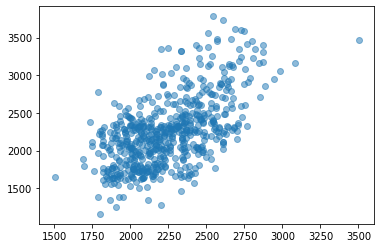

In [150]:
'''
Visually inspect linearity between target variable (y1) and predictions
'''
plt.plot(model_predictions.predicted_y1,model_predictions.y1,'o',alpha=0.5)
plt.show()

### 4.3) Normality of Errors

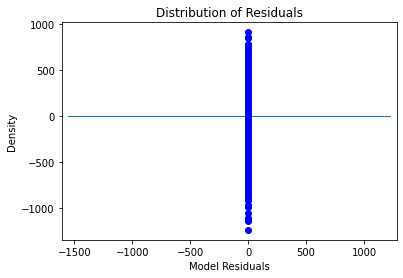

In [151]:
'''
Visually inspect the residuals to confirm normality
'''

fig = sm.qqplot(model_predictions.residuals)
sns.kdeplot(model_predictions.residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

### 4.4) Absence of Multicollinearity

In [152]:
'''
Multicollinearity was checked and handled during data pre-processing stage.
'''

'\nMulticollinearity was checked and handled during data pre-processing stage.\n'

### 4.5) Homoscedasticity


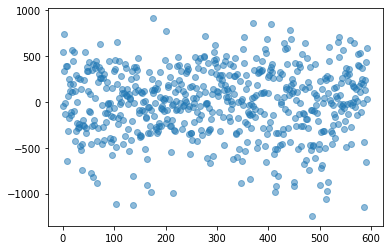

In [153]:
'''
Visually inspect residuals to confirm constant variance
'''
plt.plot(model_predictions.residuals,'o',alpha=0.5)
plt.show()

### 4.6) Absence of Autocorrelation of the residuals

In [154]:
'''
The Durbin Watson test is a statistical test for detecting autocorrelation of the 
model residuals
'''

dw = durbin_watson(model_predictions.residuals)
print('Durbin-Watson',dw)

Durbin-Watson 1.6685204521746255


In [155]:
if dw < 1.5:
        print('Positive autocorrelation', '\n')
elif dw > 2.5:
        print('Negative autocorrelation', '\n')
else:
        print('Little to no autocorrelation', '\n')


Little to no autocorrelation 

